In [126]:
# Setup:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics.classification import BinaryAUROC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [127]:
test_set = pd.read_csv('data/test.csv')
training_set = pd.read_csv('data/train.csv')

In [128]:
means = None
stdevs = None

# Define preprocessing transform
def conversion_transform(df, is_test = False):
    # drop text columns
    new_df = df.drop(columns=['track_href', 'uri', 'type', 'analysis_url'])

    if is_test == True:
        new_df = new_df.drop(columns=['ID'])

    # Handle dates 
    date_column = new_df["track_album_release_date"].astype(str)

    parsed = pd.to_datetime(date_column, format='%Y-%m-%d', errors='coerce')
    new_df["year"] = parsed.dt.year
    new_df["month"] = parsed.dt.month
    new_df["day"] = parsed.dt.day

    # For year-only dates, extract year and default month/day to 1
    year_only_mask = new_df["year"].isna()
    new_df.loc[year_only_mask, "year"] = pd.to_numeric(date_column[year_only_mask], errors='coerce')
    new_df.loc[year_only_mask, "month"] = np.nan
    new_df.loc[year_only_mask, "day"] = np.nan

    new_df = new_df.drop(columns='track_album_release_date')

    if is_test == False:
        # Binarization of the output
        column_names = list(new_df.columns.values)
        column_names.append(column_names.pop(column_names.index('Popularity_Type')))
        new_df = new_df[column_names]

        new_df['Popularity_Type'] = new_df['Popularity_Type'].map({'High': 1, 'Low': 0})

    return new_df

def normalization_transform(df, is_test = False):
    # normalize data
    new_df = df.copy()
    if is_test == False:
        new_df.iloc[:, :-1] -= means
        new_df.iloc[:, :-1] /= stdevs
    else: 
        new_df = new_df[feature_columns]
        new_df -= means
        new_df /= stdevs
    # replace all the nan values with zero
    new_df = new_df.fillna(0)
    return new_df

def preprocessing(df, is_test= False):
    new_df = conversion_transform(df, is_test)
    new_df = normalization_transform(new_df, is_test)
    return new_df

# compute normalization mean and stdev
filtered_training = conversion_transform(training_set)
means = np.nanmean(filtered_training.iloc[:, :-1], axis=0)
stdevs = np.nanstd(filtered_training.iloc[:, :-1], axis=0)
feature_columns = list(filtered_training.columns[:-1])

filtered_training = preprocessing(training_set)

# Save IDs
test_IDs = test_set['ID'].values

In [129]:
# Music Dataloader
class MusicDataset(Dataset):
    """Music dataset."""

    def __init__(self, dataset, is_test, transform=None):
        """
        Arguments:
            dataset: Pandas dataframe
            transform: Transformation to data
        """

        data = dataset
        if transform:
            data = transform(dataset, is_test)

        # If it's the test set, there are no labels 
        if is_test:
            self.X = torch.tensor( data.values, dtype=torch.float32)
            self.y = None

        else:
        # example: last column is label, rest are features
            self.X = torch.tensor(
                data.iloc[:, :-1].values,
                dtype=torch.float32
            )
            self.y = torch.tensor(
                data.iloc[:, -1].values,
                dtype=torch.long
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [130]:
num_features = filtered_training.shape[1]-1
neuralnet = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(128, 32),
    nn.GELU(),
    nn.Dropout(0.25),

    nn.Linear(32,1),
    nn.Sigmoid()
)

In [131]:
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=5*1e-4)
loss_fn = nn.BCELoss()

In [132]:
# split and load the data 
dataset = MusicDataset(training_set, is_test=False, transform=preprocessing)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
split_sizes = [train_size, test_size]

train_dataset, valid_dataset = random_split(dataset, split_sizes, generator=torch.Generator().manual_seed(42))

training_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [133]:
def evaluate(model, dataset):
    # Switch to the evaluation mode: 
    model.eval()
    auroc_metric = BinaryAUROC(thresholds=None)

    # Compute the predictions and compare to the true labels
    pred = model(dataset.dataset.X[dataset.indices])
    auroc_metric.update(pred, dataset.dataset.y[dataset.indices])
    acc = auroc_metric.compute().numpy().item()
    model.train() 
    
    return acc

In [134]:
neuralnet.train()
train_error = []
test_error = []

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(training_data_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = neuralnet(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target.float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
    train_error.append(evaluate(neuralnet, train_dataset))
    print('Accuracy on the training set is', evaluate(neuralnet, train_dataset))
    test_error.append(evaluate(neuralnet, valid_dataset))
    print('Accuracy on the testing set is', evaluate(neuralnet, valid_dataset))

Train Epoch: 1  Loss: 0.4156
Accuracy on the training set is 0.7691843509674072
Accuracy on the testing set is 0.7731087803840637
Train Epoch: 2  Loss: 0.2898
Accuracy on the training set is 0.7847025394439697
Accuracy on the testing set is 0.7856179475784302
Train Epoch: 3  Loss: 0.5230
Accuracy on the training set is 0.793056845664978
Accuracy on the testing set is 0.7908454537391663
Train Epoch: 4  Loss: 0.4835
Accuracy on the training set is 0.8017342686653137
Accuracy on the testing set is 0.7983124256134033
Train Epoch: 5  Loss: 0.3302
Accuracy on the training set is 0.8063692450523376
Accuracy on the testing set is 0.8004478812217712
Train Epoch: 6  Loss: 0.4569
Accuracy on the training set is 0.8100747466087341
Accuracy on the testing set is 0.8022200465202332
Train Epoch: 7  Loss: 0.4053
Accuracy on the training set is 0.8160372972488403
Accuracy on the testing set is 0.8007444143295288
Train Epoch: 8  Loss: 0.5808
Accuracy on the training set is 0.8184596300125122
Accuracy on

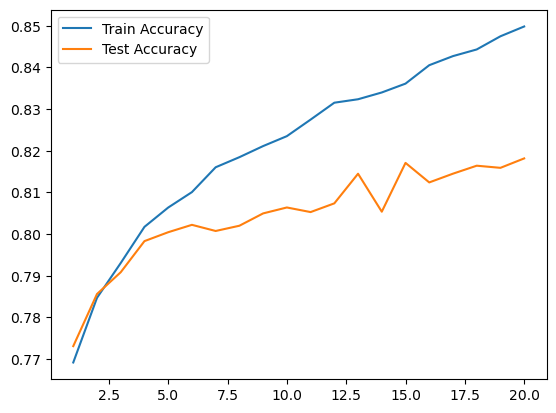

In [135]:
epochs = np.linspace(1,20, 20)
plt.plot(epochs, train_error, label = 'Train Accuracy')
plt.plot(epochs, test_error, label = 'Test Accuracy')
plt.legend()

In [136]:
# Now let's produce the output on the test_set 
torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

In [137]:
### Now let's train an XGboost and/or Random Forest Model

dataset = MusicDataset(training_set, is_test= False, transform=preprocessing)
X_np = dataset.X.numpy()
y_np = dataset.y.numpy()

torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

X_test_np = torch_test.X.numpy()

# X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size= 0.15, random_state=37)
XGboost = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = 6)
XGboost.fit(X_np, y_np)
y_pred = XGboost.predict_proba(X_test_np)[:,1]

In [138]:
# rfc_clf = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=150)
# rfc_clf.fit(X_train, y_train)
# y_pred = rfc_clf.predict(X_test)
# acc = accuracy_score(y_pred, y_test)
# print(acc)

# Ensemble selection

In [143]:
# Divide up data
X_train = train_dataset.dataset.X[train_dataset.indices].squeeze()
y_train = train_dataset.dataset.y[train_dataset.indices].squeeze()
X_valid = valid_dataset.dataset.X[valid_dataset.indices].squeeze()
y_valid = valid_dataset.dataset.y[valid_dataset.indices].squeeze()

In [144]:
def ensemble_selection(models, valid_pred, y_valid, max_size, resampling=False):
    """
    Performs ensemble selection given a list of models trained on test to
    maximize AUC

    Args:
        models: array of models trained
        valid_pred: predictions for validation set
        y_valid: true values for validation set
    
    Returns:
        Ensemble of models that maximizes AUC on the validation set
    """
    ensemble = []
    remaining = list(models)

    best_auc = 0
    while len(ensemble) < max_size:
        best_model = None

        for m in remaining:
            candidate = ensemble + [m]
            preds = np.mean([valid_pred[x] for x in candidate], axis=0)
            auc = roc_auc_score(y_valid, preds)

            if auc >= best_auc:
                best_auc = auc
                best_model = m

        if best_model is None:
            break

        ensemble.append(best_model)
        if not resampling:
            remaining.remove(best_model)
        print(best_auc)

    return ensemble

In [ ]:
# List of parameters
nn_params_list = [
    dict(hidden_units=64,  dropout=0.5,  lr=1e-3),
    dict(hidden_units=128, dropout=0.3,  lr=5e-4),
    dict(hidden_units=256, dropout=0.2,  lr=3e-4),
    dict(hidden_units=32, dropout=0.1,  lr=1e-4),
]

xgboost_params_list = [ 
    dict(max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8), 
    dict(max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8), 
    dict(max_depth=8, learning_rate=0.03, subsample=0.7, colsample_bytree=0.7),
]

random_forest_params_list = [
    dict(max_depth=8, max_features=0.5),
    dict(max_depth=12, max_features="sqrt"),
    dict(max_depth=None, max_features=0.3),
]

light_gbm_params_list = [
    dict(num_leaves=31, learning_rate=0.05, feature_fraction=0.4),
    dict(num_leaves=63, learning_rate=0.03, feature_fraction=0.3)
]

logistic_params_list = [
    dict(C=10**n) for n in range(-2, 3)
]

# Training models
def train_nn(hidden_units, dropout, lr):
    # Define neural network
    neuralnet = nn.Sequential(
        nn.Linear(num_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_units, hidden_units // 2),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_units // 2, 1),
        nn.Sigmoid()
    )

    # Define optimizer and loss function
    optimizer = torch.optim.NAdam(neuralnet.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    # Training model
    neuralnet.train()
    for _ in range(20):
        for _, (data, target) in enumerate(training_data_loader):
            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = neuralnet(data)

            # Calculate loss
            loss = loss_fn(output.squeeze(), target.float())

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

    # turn off training
    neuralnet.eval()
    return neuralnet

def train_xgboost(max_depth, learning_rate, subsample, colsample_bytree):
    model = XGBClassifier(objective='binary:logistic', 
                          n_estimators = 100, max_depth = max_depth,
                          learning_rate = learning_rate, subsample = subsample,
                          colsample_bytree = colsample_bytree)
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_random_forest(max_depth, max_features):
    model = RandomForestClassifier(criterion='entropy', n_estimators=100,
                          max_depth=max_depth, max_features=max_features)
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_light_gbm(num_leaves, learning_rate, feature_fraction):
    model = LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate,
                           feature_fraction=feature_fraction)
    model.fit(X_train.numpy(), y_train.numpy())
    return model

def train_logistic(C):
    model = LogisticRegression(C=C, penalty='l2')
    model.fit(X_train.numpy(), y_train.numpy())
    return model
    

In [157]:
# Train all nn models and evaluate on validation
nn_models = []
for param in nn_params_list:
    nn_models += [train_nn(param['hidden_units'], param['dropout'], param['lr'])]

with torch.no_grad():
    nn_valid_pred = { 
        model: model(X_valid).numpy().flatten()
        for model in nn_models 
    }

In [158]:
# Train XGBoost and evaluate on validation
xgboost_models = []
for param in xgboost_params_list:
    xgboost_models += [train_xgboost(param['max_depth'], 
                                     param['learning_rate'],
                                     param['subsample'],
                                     param['colsample_bytree'])]

xgboost_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in xgboost_models 
}

In [159]:
# Train Random Forest and evaluate on validation
random_forest_models = []
for param in random_forest_params_list:
    random_forest_models += [train_random_forest(param['max_depth'], 
                                                 param['max_features'])]

random_forest_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in random_forest_models 
}

In [160]:
# Train Random Forest and evaluate on validation
lgbm_models = []
for param in light_gbm_params_list:
    lgbm_models += [train_light_gbm(param['num_leaves'], 
                                    param['learning_rate'],
                                    param['feature_fraction'])]

lgbm_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in lgbm_models 
}

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Number of positive: 1093, number of negative: 1998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 3091, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353607 -> initscore=-0.603220
[LightGBM] [Info] Start training from score -0.603220
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [I

/home/ssinha/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ssinha/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [161]:
# Train Logistic Regression and evaluate on validation
logistic_models = []
for param in logistic_params_list:
    logistic_models += [train_logistic(param['C'])]

logistic_valid_pred = { 
    model: model.predict_proba(X_valid)[:, 1]
    for model in logistic_models 
}

In [162]:
# Combine everything
models = nn_models + xgboost_models + random_forest_models + lgbm_models + logistic_models
valid_pred = nn_valid_pred | xgboost_valid_pred | random_forest_valid_pred | lgbm_valid_pred | logistic_valid_pred
print(f'Ensemble draws from {len(models)} models')

Ensemble draws from 17 models


In [163]:
# Run ensemble method
ensemble = ensemble_selection(models, valid_pred, y_valid.numpy(), max_size=len(models) * 2, resampling=True)

0.8526938648396137
0.8561566638489716
0.8567053728997048
0.8568536726431463
0.8568610876303184
0.8569871424122436
0.8570168023609319


In [164]:
# Check types of models contained
for model in ensemble:
    print(type(model))

<class 'lightgbm.sklearn.LGBMClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
<class 'lightgbm.sklearn.LGBMClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
<class 'lightgbm.sklearn.LGBMClassifier'>


In [165]:
# Evaluate on test
def evaluate_ensemble(ensemble, X):
    test_pred = np.zeros(X.numpy().shape[0])
    for model in ensemble:
        if type(model) is torch.nn.modules.container.Sequential:
            with torch.no_grad():
                test_pred += model(X).numpy().flatten()
        else:
            test_pred += model.predict_proba(X)[:, 1]
    return test_pred / len(ensemble)

y_test = evaluate_ensemble(ensemble, torch_test.X)
y_test

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/ssinha/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ssinha/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ssinha/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array([0.52366279, 0.33571607, 0.53410744, 0.75290004, 0.38113314,
       0.13480957, 0.38171675, 0.29982373, 0.82243343, 0.45569975,
       0.32043815, 0.35017649, 0.41150022, 0.3282221 , 0.45861819,
       0.53201886, 0.2846319 , 0.03681849, 0.06025528, 0.29777526,
       0.28706877, 0.0805309 , 0.02176831, 0.03562048, 0.18200197,
       0.2513908 , 0.43667921, 0.46694592, 0.14163237, 0.18786819,
       0.37171238, 0.45167507, 0.034447  , 0.035864  , 0.15246401,
       0.18021096, 0.25397797, 0.08202546, 0.37479402, 0.26947075,
       0.3970998 , 0.06754565, 0.42335857, 0.3556239 , 0.05557086,
       0.59391747, 0.79297848, 0.03107903, 0.39295315, 0.16950478,
       0.69223496, 0.48511285, 0.2307443 , 0.82042351, 0.05053305,
       0.05425798, 0.22021825, 0.3439637 , 0.15814923, 0.49566905,
       0.29935455, 0.60409276, 0.02109435, 0.28877584, 0.02901673,
       0.42316229, 0.61551929, 0.02516461, 0.04051706, 0.43290057,
       0.03496423, 0.19485658, 0.43350456, 0.14842016, 0.58142

In [155]:
# Save to file
submission5 = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': y_test
})
submission5.to_csv('submission5.csv', index=False)

In [ ]:
X_train

tensor([[ 2.6859,  1.6069,  0.8017,  ...,  0.3045, -0.7894, -1.2838],
        [ 0.1497,  0.7644,  1.3146,  ...,  0.1172, -1.0855,  1.6308],
        [ 0.1497,  0.3732,  0.4104,  ...,  0.3981,  0.6912, -0.5282],
        ...,
        [ 0.1497, -0.6118,  1.1084,  ...,  0.6791, -1.6777,  1.1990],
        [ 0.1497,  0.9449,  0.9180,  ...,  0.6791,  0.9873,  1.7387],
        [ 0.1497, -0.5476,  0.5585,  ...,  0.4918, -0.7894,  0.6593]])